In [ ]:
from pennylane import numpy as np
from pennylane.numpy import _np
import pennylane as qml

from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons


class QuantumRBFKernel:
    def __init__(self, n_clusters=3, sigma=1.0, alpha=1.0, beta=1.0, max_iter=100):
        self.n_clusters = n_clusters
        self.sigma = sigma  # Parâmetro do RBF
        self.alpha = alpha  # Peso do Intra Loss
        self.beta = beta    # Peso do Inter Loss
        self.max_iter = max_iter
        self.clusters = None
        self.K = None       # Matriz do kernel
        self.X_quantum = None  # Espaço quântico de características

    def _compute_rbf_kernel(self, X):        
        # Soma dos quadrados de cada linha (vetores ϕ(x))
        X_norm_sq = np.sum(X**2, axis=1, keepdims=True) # shape (n_samples, 1)

        # Usando a fórmula: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x·y
        dist_sq = X_norm_sq + X_norm_sq.T - 2 * np.dot(X, X.T)

        # Aplicando a função RBF
        K = np.exp(-dist_sq / (2 * self.sigma**2))
        return K

    def _initialize_clusters(self, n):
        """Inicializa clusters aleatoriamente."""
        return np.random.randint(0, self.n_clusters, n)

    def _compute_intra_loss(self):
        """Calcula o Intra Loss."""
        intra_loss = 0.0
        for j in range(self.n_clusters):
            indices = np.where(self.clusters == j)[0]
            if len(indices) == 0:
                continue
            term1 = np.sum(np.diag(self.K)[indices])
            term2 = (1 / len(indices)) * np.sum(self.K[indices][:, indices])
            intra_loss += term1 - term2
        return intra_loss

    def _compute_inter_loss(self):
        """Calcula o Inter Loss."""
        inter_loss = 0.0
        cluster_indices = [np.where(self.clusters == j)[0] for j in range(self.n_clusters)]
        for j in range(self.n_clusters):
            for l in range(j + 1, self.n_clusters):
                indices_j = cluster_indices[j]
                indices_l = cluster_indices[l]
                if len(indices_j) == 0 or len(indices_l) == 0:
                    continue
                # Termo K(μ_j, μ_j)
                K_jj = (1 / len(indices_j)**2) * np.sum(self.K[indices_j][:, indices_j])
                # Termo K(μ_l, μ_l)
                K_ll = (1 / len(indices_l)**2) * np.sum(self.K[indices_l][:, indices_l])
                # Termo K(μ_j, μ_l)
                K_jl = (1 / (len(indices_j) * len(indices_l))) * np.sum(self.K[indices_j][:, indices_l])
                # Distância entre centróides
                distance = K_jj + K_ll - 2 * K_jl
                inter_loss += distance
        return inter_loss

    def fit(self, X_quantum):
        """Treina o modelo com os dados no espaço quântico."""
        self.X_quantum = np.array(X_quantum, requires_grad=False)
        n = X_quantum.shape[0]
        self.K = self._compute_rbf_kernel(self.X_quantum)
        self.clusters = self._initialize_clusters(n)

        for _ in range(self.max_iter):
            new_clusters = np.zeros(n)
            # Passo de Atribuição
            for i in range(n):
                distances = []
                for j in range(self.n_clusters):
                    indices = np.where(self.clusters == j)[0]
                    if len(indices) == 0:
                        distances.append(np.inf)
                        continue
                    term1 = self.K[i, i]
                    term2 = (2 / len(indices)) * np.sum(self.K[i, indices])
                    term3 = (1 / len(indices)**2) * np.sum(self.K[indices][:, indices])
                    distance = term1 - term2 + term3
                    distances.append(distance)
                new_clusters[i] = np.argmin(distances)
            
            if np.all(self.clusters == new_clusters):
                break
            self.clusters = new_clusters.copy()

        return self

    def compute_total_cost(self):
        """Calcula o custo total J = α * Intra Loss - β * Inter Loss."""
        intra = self._compute_intra_loss()
        inter = self._compute_inter_loss()
        return self.alpha * intra - self.beta * inter

    def assign_cluster(self, x_new_quantum):
        """Atribui um novo ponto a um cluster."""
        K_new = np.array([np.exp(-np.linalg.norm(x_new_quantum - x)**2 / (2 * self.sigma**2)) for x in self.X_quantum])
        distances = []
        for j in range(self.n_clusters):
            indices = np.where(self.clusters == j)[0]
            if len(indices) == 0:
                distances.append(np.inf)
                continue
            term1 = K_new[j]  # K(x_new, x_new) = 1 para RBF (se normalizado)
            term2 = (2 / len(indices)) * np.sum(K_new[indices])
            term3 = (1 / len(indices)**2) * np.sum(self.K[indices][:, indices])
            distance = term1 - term2 + term3
            distances.append(distance)
        return np.argmin(distances)

In [9]:
def angle_embedding(x, wires):
    for i in wires:
        if i % 2 == 0:
            qml.RY(x[0] * np.pi, wires=i)
        else:
            qml.RX(x[1] * np.pi, wires=i)

# Ampliture Embedding
def amplitude_embedding(x, wires):
    qml.AmplitudeEmbedding(features=x, pad_with=2, wires=wires, normalize=True)

# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    # Replicar dados: x[0] em qubits 0 e 2; x[1] em qubits 1 e 3
    for i in wires:
        if i % 2 == 0:
            qml.RX(x[0] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])   
        else:
            qml.RX(x[1] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_qubits, n_entanglement):
    for camada in range(len(W)):
        # Aplica rotações em cada qubit para a camada atual
        for qubit in range(n_qubits):
            params = W[camada][qubit]
            qml.Rot(params[0], params[1], params[2], wires=qubit)
        
        # Aplica o entrelaçamento baseado em n_entanglement
        for ent in range(n_entanglement):
            # Alterna o padrão de entrelaçamento com base na camada, ent e qubit
            for q in range(n_qubits - 1):
                if (camada + ent + q) % 2 == 0:
                    controle = q
                    alvo = (q + 1) % n_qubits
                else:
                    controle = (q + 1) % n_qubits
                    alvo = q
                qml.CNOT(wires=[controle, alvo])


def circuit(weights, X, n_quibits, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        angle_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(X, wires=range(n_quibits))

    entanglement(weights, n_quibits, n_entanglement)

    # return qml.expval(qml.PauliZ(wires=0))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_quibits)]

def create_device(n_quibits):
    return qml.device("lightning.gpu", wires=n_quibits)

def create_qnode(n_quibits, n_entanglement, embedding_type):
    dev = create_device(n_quibits)

    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def qnode(weights, X):
        return circuit(weights, X, n_quibits, n_entanglement, embedding_type)

    return qnode

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

In [3]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

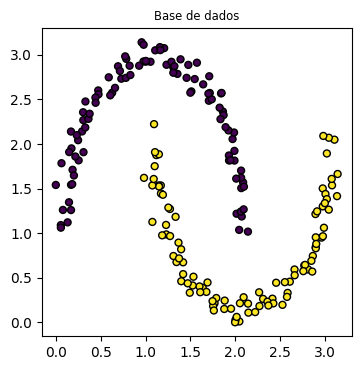

In [4]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)
X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)


In [12]:
n_qubits = 2
n_params = 3
n_layers = 4
n_entanglement = 1
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

# Função para otimizar
def cost_function(weights, bias, X):
    # Mapear dados para o espaço quântico
    X_quantum = np.array([qvc_classifier(qnode, weights, bias, x) for x in X])
    # Treinar Kernel K-means e calcular custo
    model = QuantumRBFKernel(n_clusters=2, sigma=0.5)
    model.fit(X_quantum)
    return model.compute_total_cost()

weights_init = np.random.uniform(
        -np.pi, np.pi, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
bias_init = np.array(0.0, requires_grad=True)

weights = weights_init
bias = bias_init
opt = qml.SPSAOptimizer(maxiter=100)

for _ in range(50):
    wrapped_cost_function = lambda w, b: cost_function(w, b, X)
    params = [weights, bias]
    (weights, bias), J = opt.step_and_cost(wrapped_cost_function, *params)
    print(f"Custo J: {J:.4f}")

print("Parâmetros otimizados:", weights, bias)

Custo J: 81.0386
Custo J: 100.7269
Custo J: 91.5065
Custo J: 60.1949
Custo J: 68.3274
Custo J: 111.8327
Custo J: 51.0274
Custo J: 63.7399
Custo J: 66.6774
Custo J: 76.9227
Custo J: 92.8087
Custo J: 74.8284
Custo J: 69.4828
Custo J: 71.7109
Custo J: 107.2894
Custo J: 98.9448
Custo J: 64.4194
Custo J: 80.4653
Custo J: 94.8103
Custo J: 81.0695
Custo J: 63.9693
Custo J: 74.1920
Custo J: 100.4151
Custo J: 93.7544
Custo J: 70.7482
Custo J: 82.0501
Custo J: 44.8903
Custo J: 84.8791
Custo J: 99.5547
Custo J: 75.6191
Custo J: 71.3911
Custo J: 87.1247
Custo J: 83.7563
Custo J: 87.5793
Custo J: 81.8198
Custo J: 87.2179
Custo J: 56.1819
Custo J: 84.7545
Custo J: 82.3812
Custo J: 91.1118
Custo J: 85.7701
Custo J: 90.8097
Custo J: 93.1056
Custo J: 95.2792
Custo J: 81.5733
Custo J: 72.2948
Custo J: 87.8407
Custo J: 87.9828
Custo J: 91.3496
Custo J: 66.0764
Parâmetros otimizados: [[[ -0.68439869   0.31543949   7.17848418]
  [  4.15987186   6.70042504  -5.86166299]]

 [[  0.33200302  -6.58162367  -4.06

In [22]:
n_qubits = 4  # Número de qubits
n_entanglement = 2  # Camadas de entrelaçamento
embedding_type = "AE"  # Escolher entre 'AE', 'MEE', ou 'AmpE'

# Criar o dispositivo e o qnode
dev = qml.device("lightning.gpu", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def quantum_circuit(weights, x):
    if embedding_type == 'AE':
        angle_embedding(x, wires=range(n_qubits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(x, wires=range(n_qubits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(x, wires=range(n_qubits))
    
    entanglement(weights, n_qubits, n_entanglement)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumMoonClustering:
    def __init__(self, n_clusters=2, sigma=0.5, alpha=1.0, beta=1.0, max_iter=100):
        self.n_clusters = n_clusters
        self.sigma = sigma
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.weights = None  # Parâmetros do circuito
        self.X_train_quantum = None
        self.model = None

    def _compute_rbf_kernel(self, X):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (2 * self.sigma**2))
        return K

    def _kernel_kmeans(self, K):
        clusters = np.random.randint(0, self.n_clusters, K.shape[0])
        for _ in range(self.max_iter):
            new_clusters = np.zeros(K.shape[0])
            for i in range(K.shape[0]):
                distances = []
                for j in range(self.n_clusters):
                    indices = np.where(clusters == j)[0]
                    if len(indices) == 0:
                        distances.append(np.inf)
                        continue
                    term1 = K[i, i]
                    term2 = (2 / len(indices)) * np.sum(K[i, indices])
                    term3 = (1 / len(indices)**2) * np.sum(K[indices][:, indices])
                    distances.append(term1 - term2 + term3)
                new_clusters[i] = np.argmin(distances)
            if np.all(clusters == new_clusters):
                break
            clusters = new_clusters.copy()
        return clusters

    def _cost_function(self, weights_flat, X):
        # Reshape dos pesos para a estrutura do circuito
        weights = weights_flat.reshape((n_entanglement, n_qubits, 3))
        
        # Mapear dados para o espaço quântico
        X_quantum = np.array([quantum_circuit(weights, x) for x in X])
        
        # Calcular kernel e clusters
        K = self._compute_rbf_kernel(X_quantum)
        clusters = self._kernel_kmeans(K)
        
        # Calcular perdas intra e inter
        intra_loss = 0.0
        inter_loss = 0.0
        cluster_indices = [np.where(clusters == j)[0] for j in range(self.n_clusters)]
        
        for j in range(self.n_clusters):
            indices = cluster_indices[j]
            if len(indices) == 0:
                continue
            intra_loss += np.sum(np.diag(K)[indices]) - (1 / len(indices)) * np.sum(K[indices][:, indices])
            
            for l in range(j + 1, self.n_clusters):
                indices_l = cluster_indices[l]
                if len(indices_l) == 0:
                    continue
                K_jj = (1 / len(indices)**2) * np.sum(K[indices][:, indices])
                K_ll = (1 / len(indices_l)**2) * np.sum(K[indices_l][:, indices_l])
                K_jl = (1 / (len(indices) * len(indices_l))) * np.sum(K[indices][:, indices_l])
                inter_loss += K_jj + K_ll - 2 * K_jl
        
        return self.alpha * intra_loss - self.beta * inter_loss

    def fit(self, X_train):
        # Inicializar pesos do circuito
        weights_shape = (n_entanglement, n_qubits, 3)
        self.weights = 0.1 * np.random.randn(*weights_shape, requires_grad=True)
        
        # Otimização dos pesos
        opt = qml.AdamOptimizer(stepsize=0.01)
        for _ in range(50):
            self.weights_flat = opt.step(
                lambda w: self._cost_function(w, X_train), 
                self.weights
            )
            self.weights = self.weights_flat.reshape(weights_shape)
        
        # Treinamento final
        self.X_train_quantum = np.array([quantum_circuit(self.weights, x) for x in X_train])
        K = self._compute_rbf_kernel(self.X_train_quantum)
        self.clusters = self._kernel_kmeans(K)
        return self

    def assign_cluster(self, x_new):
        x_new_quantum = quantum_circuit(self.weights, x_new)
        K_new = np.array([np.exp(-np.linalg.norm(x_new_quantum - x)**2 / (2 * self.sigma**2))
                          for x in self.X_train_quantum])
        
        distances = []
        for j in range(self.n_clusters):
            indices = np.where(self.clusters == j)[0]
            if len(indices) == 0:
                distances.append(np.inf)
                continue
            term1 = 1.0
            term2 = (2 / len(indices)) * np.sum(K_new[indices])
            term3 = (1 / len(indices)**2) * np.sum(K_new[indices][:, indices])
            distances.append(term1 - term2 + term3)
        
        return np.argmin(distances)


In [23]:
# Instanciar e treinar o modelo
model = QuantumMoonClustering(n_clusters=2, sigma=0.5)
model.fit(X)

# Atribuir clusters aos dados de teste
clusters_test = np.array([model.assign_cluster(x) for x in X])

# Visualização (opcional)
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=model.clusters, cmap='viridis', label='Train')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters_test, cmap='viridis', marker='x', label='Test')
plt.legend()
plt.show()

ValueError: setting an array element with a sequence.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons, make_circles

# Configurações quânticas
n_qubits = 4            # Número de qubits
n_entanglement = 6       # Camadas de entrelaçamento aumentadas
embedding_type = "AE"  # Usando amplitude embedding (mais expressivo)

# Criar dispositivo quântico
dev = qml.device("lightning.gpu", wires=n_qubits)

# Circuito quântico modificado
@qml.qnode(dev, interface="autograd")
def quantum_circuit(weights, x):
    # Embedding quântico
    if embedding_type == 'AE':
        qml.AngleEmbedding(x, wires=range(n_qubits))
    elif embedding_type == 'AmpE':
        qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), normalize=True)
    
    # Camadas variacionais com entrelaçamento
    for layer in range(n_entanglement):
        for i in range(n_qubits):
            qml.Rot(*weights[layer][i], wires=i)
        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumMoonClustering:
    def __init__(self, n_clusters=2, max_iter=100, reg=0.01):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.reg = reg          # Parâmetro de regularização
        self.weights = None
        self.cluster_means = None
        self.global_mean = None

    def _compute_linear_kernel(self, X):
        """Kernel linear no espaço quântico"""
        return X @ X.T

    def _fisher_cost(self, X_quantum, clusters):
        """Função de custo baseada no critério de Fisher"""
        # Estatísticas dos clusters
        cluster_indices = [np.where(clusters == j)[0] for j in range(self.n_clusters)]
        
        # Médias
        self.global_mean = np.mean(X_quantum, axis=0)
        self.cluster_means = [np.mean(X_quantum[indices], axis=0) for indices in cluster_indices]
        
        # Matrizes de dispersão
        S_W = sum([np.cov(X_quantum[indices].T) for indices in cluster_indices])
        S_B = sum([len(indices)*np.outer((mean - self.global_mean), (mean - self.global_mean))
                   for indices, mean in zip(cluster_indices, self.cluster_means)])
        
        # Razão de Fisher com regularização
        fisher_ratio = np.trace(S_B) / (np.trace(S_W) + 1e-8)
        return -fisher_ratio + self.reg * np.sum(self.weights**2)

    def _kmeans_plusplus(self, X, n_clusters):
        """Inicialização inteligente para centros dos clusters"""
        centroids = [X[np.random.randint(X.shape[0])]]
        for _ in range(n_clusters-1):
            dists = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in X])
            probs = dists / dists.sum()
            centroids.append(X[np.argmax(probs)])
        return np.array(centroids)

    def _quantum_kmeans(self, X_quantum):
        """K-means modificado para espaço quântico"""
        centroids = self._kmeans_plusplus(X_quantum, self.n_clusters)
        
        for _ in range(self.max_iter):
            # Atribuição de clusters
            distances = np.linalg.norm(X_quantum[:, None] - centroids, axis=2)
            clusters = np.argmin(distances, axis=1)
            
            # Atualização de centros
            new_centroids = np.array([X_quantum[clusters == j].mean(axis=0) 
                                  for j in range(self.n_clusters)])
            
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids
        
        return clusters

    def _cost_function(self, weights_flat, X):
        """Função de custo otimizada"""
        # Remodelar pesos
        self.weights = weights_flat.reshape((n_entanglement, n_qubits, 3))
        
        # Gerar features quânticas
        X_quantum = np.array([quantum_circuit(self.weights, x) for x in X])
        
        # Normalizar features
        X_quantum = (X_quantum - np.mean(X_quantum, axis=0)) / np.std(X_quantum, axis=0)
        
        # Clusterização inicial
        clusters = self._quantum_kmeans(X_quantum)
        
        return self._fisher_cost(X_quantum, clusters)

    def fit(self, X):
        # Normalização para Amplitude Embedding
        if embedding_type == 'AmpE':
            X = X / np.linalg.norm(X, axis=1, keepdims=True)
        
        # Inicialização de pesos
        weights_shape = (n_entanglement, n_qubits, 3)
        self.weights = 0.1 * np.random.randn(*weights_shape)
        
        # Otimização
        opt = qml.AdamOptimizer(stepsize=0.01)
        for epoch in range(100):
            self.weights = opt.step(lambda w: self._cost_function(w, X), self.weights)
            
            # Monitoramento
            if epoch % 10 == 0:
                cost = self._cost_function(self.weights, X)
                print(f"Epoch {epoch}: Cost = {cost:.4f}")
        
        # Clusterização final
        X_quantum = np.array([quantum_circuit(self.weights, x) for x in X])
        self.clusters = self._quantum_kmeans(X_quantum)
        return self

    def assign_cluster(self, x_new):
        """Atribuição de novo ponto baseada na proximidade no espaço quântico"""
        if embedding_type == 'AmpE':
            x_new = x_new / np.linalg.norm(x_new)
            
        x_quantum = quantum_circuit(self.weights, x_new)
        distances = [np.linalg.norm(x_quantum - mean) for mean in self.cluster_means]
        return np.argmin(distances)

# ----------------------------------------------------------
# Exemplo de Uso
# ----------------------------------------------------------
if __name__ == "__main__":
    # Gerar dados
    X, _ = make_moons(n_samples=200, noise=0.05)
    
    # Normalização para Amplitude Embedding
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    # Treinar modelo
    model = QuantumMoonClustering(n_clusters=2).fit(X)
    
    # Visualizar resultados
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10,5))
    
    # Plot dados originais
    plt.subplot(121)
    plt.scatter(X[:,0], X[:,1], c='blue')
    plt.title("Dados Originais")
    
    # Plot espaço quântico
    plt.subplot(122)
    X_quantum = np.array([quantum_circuit(model.weights, x) for x in X])
    plt.scatter(X_quantum[:,0], X_quantum[:,1], c=model.clusters)
    plt.title("Espaço Quântico Transformado")
    
    plt.show()

NotImplementedError: VJP of cov wrt argnums (0,) not defined

Step 0: Cost = -672.3497
Step 10: Cost = -1308.1367
Step 20: Cost = -1597.3913
Step 30: Cost = -1688.0033
Step 40: Cost = -1700.9860


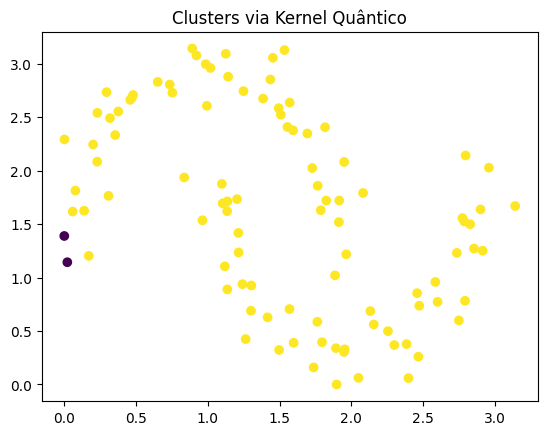

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configurações
np.random.seed(42)
n_qubits = 2  # 2 features (moons)
dev = qml.device("default.qubit", wires=n_qubits)

# Gerar dados
X, _ = make_moons(n_samples=100, noise=0.1)
scaler = MinMaxScaler(feature_range=(0, np.pi))  # Normalizar para rotações
X = scaler.fit_transform(X)

# Circuito quântico para o kernel
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    # Codificação dos dados e camadas variacionais
    for x in [x1, x2]:
        AngleEmbedding(x, wires=range(n_qubits), rotation="Y")
        # for i in range(n_qubits):
        #     qml.RY(params[i], wires=i)
        # qml.CZ(wires=[0, 1])
        # for i in range(n_qubits):
        #     qml.RY(params[i + n_qubits], wires=i)
        qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=dev.wires)  # Inverter para o kernel
    return qml.probs(wires=range(n_qubits))

# Função de kernel
def kernel(x1, x2):
    return kernel_circuit(x1, x2)[0]

# Circuito para medir o qubit de cluster
@qml.qnode(dev)
def cluster_circuit(x, params):
    AngleEmbedding(x, wires=range(n_qubits), rotation="Y")
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    qml.CZ(wires=[0, 1])
    for i in range(n_qubits):
        qml.RY(params[i + n_qubits], wires=i)
    return qml.expval(qml.PauliZ(0))

# Função de custo com kernel
def cost(params, beta=5.0):
    # Calcular matriz de kernel
    K = qml.kernels.square_kernel_matrix(X, kernel, assume_normalized_kernel=True)
    
    # Obter expectativas e atribuições suaves
    expectations = np.array([cluster_circuit(x, params) for x in X])
    p = 1 / (1 + np.exp(-beta * expectations))  # Atribuição suave via sigmoide
    
    # Calcular termos intra-cluster e inter-cluster
    intra = np.sum(K * (np.outer(p, p) + np.outer(1-p, 1-p)))
    inter = np.sum(K * (np.outer(p, 1-p) + np.outer(1-p, p)))
    
    return inter - intra  # Minimizar similaridade inter-cluster

# Inicializar parâmetros
params = np.random.normal(0, np.pi, size=2 * n_qubits, requires_grad=True)

# Otimização
opt = qml.AdamOptimizer(0.1)
n_steps = 50

for step in range(n_steps):
    params, current_cost = opt.step_and_cost(cost, params)
    if step % 10 == 0:
        print(f"Step {step}: Cost = {current_cost:.4f}")

# Atribuir clusters finais
final_expectations = np.array([cluster_circuit(x, params) for x in X])
final_clusters = np.where(final_expectations >= 0, 0, 1)

# Visualização
plt.scatter(X[:, 0], X[:, 1], c=final_clusters, cmap="viridis")
plt.title("Clusters via Kernel Quântico")
plt.show()

/tmp/ipykernel_9720/1430557294.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]), marker=".", s=100, c=col)
/tmp/ipykernel_9720/1430557294.py:90: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.ravel(centroid[i, 0]), np.ravel(centroid[i, 1]), marker="*", s=400, c=col, edgecolors="black")


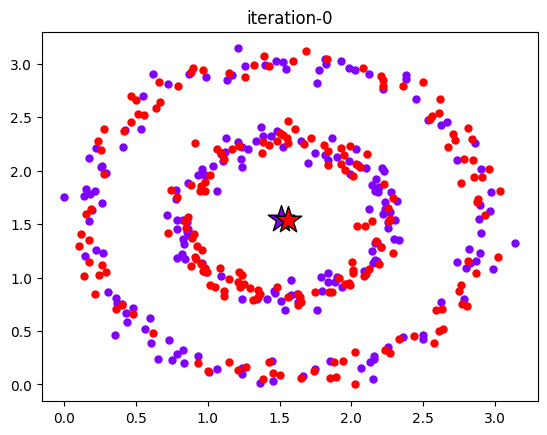

Cluster member numbers- 0 :  201
Cluster member numbers- 1 :  201
iteration- 1 :  6.0  seconds


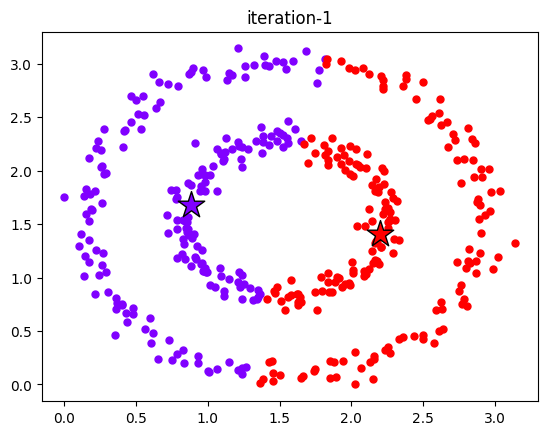

Cluster member numbers- 0 :  203
Cluster member numbers- 1 :  203
iteration- 2 :  6.0  seconds


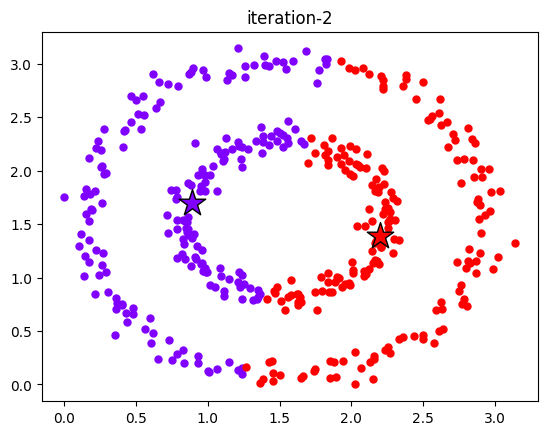

Cluster member numbers- 0 :  201
Cluster member numbers- 1 :  201
iteration- 3 :  6.0  seconds


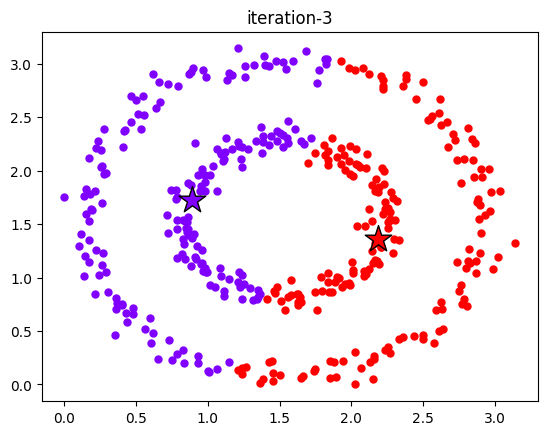

Cluster member numbers- 0 :  199
Cluster member numbers- 1 :  199
iteration- 4 :  6.0  seconds


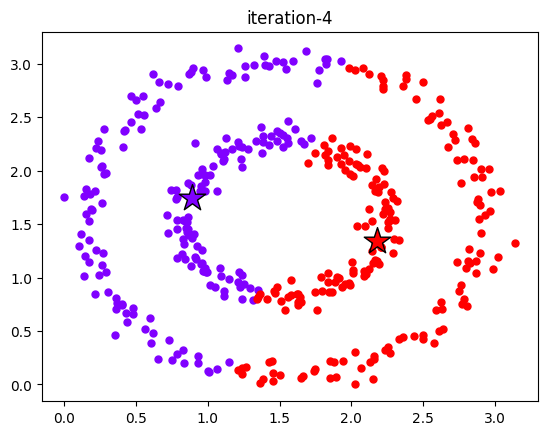

Cluster member numbers- 0 :  196
Cluster member numbers- 1 :  196
iteration- 5 :  5.0  seconds


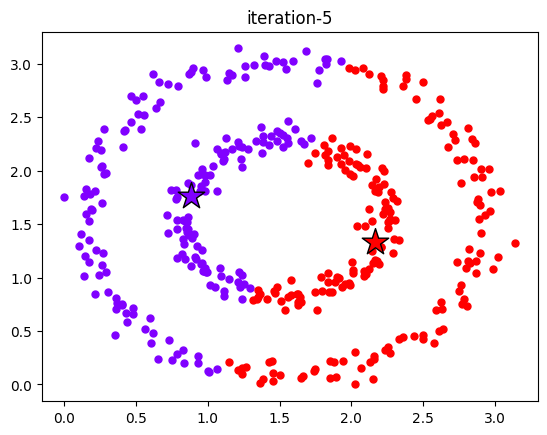

Cluster member numbers- 0 :  196
Cluster member numbers- 1 :  196
iteration- 6 :  6.0  seconds


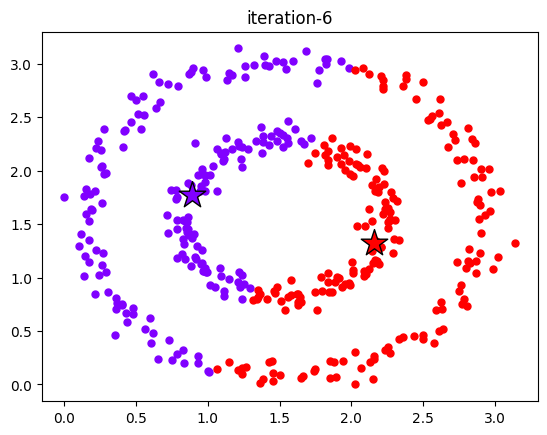

Cluster member numbers- 0 :  198
Cluster member numbers- 1 :  198
iteration- 7 :  5.0  seconds


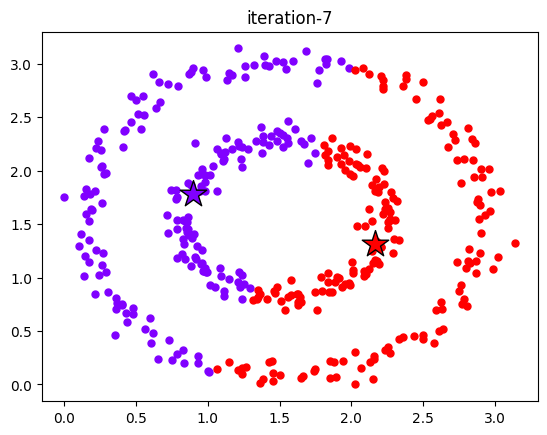

Cluster member numbers- 0 :  198
Cluster member numbers- 1 :  198
iteration- 8 :  6.0  seconds


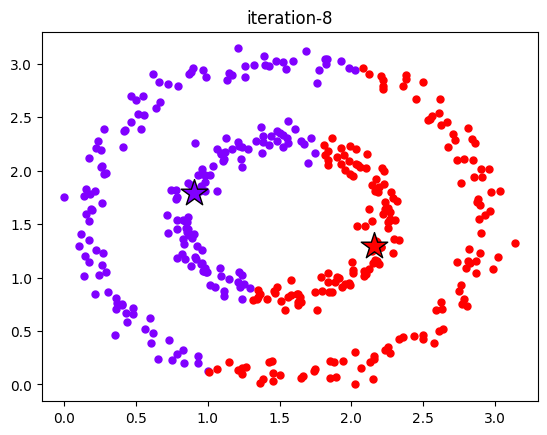

Cluster member numbers- 0 :  196
Cluster member numbers- 1 :  196
iteration- 9 :  7.0  seconds


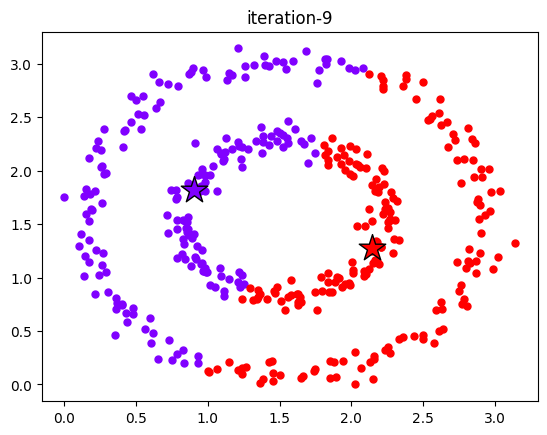

Cluster member numbers- 0 :  197
Cluster member numbers- 1 :  197
iteration- 10 :  5.0  seconds


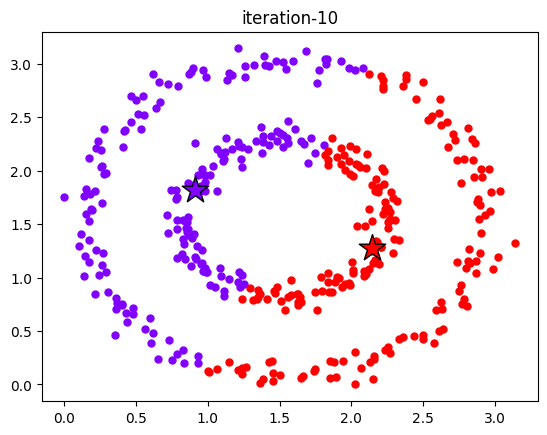

Cluster member numbers- 0 :  198
Cluster member numbers- 1 :  198
iteration- 11 :  5.0  seconds


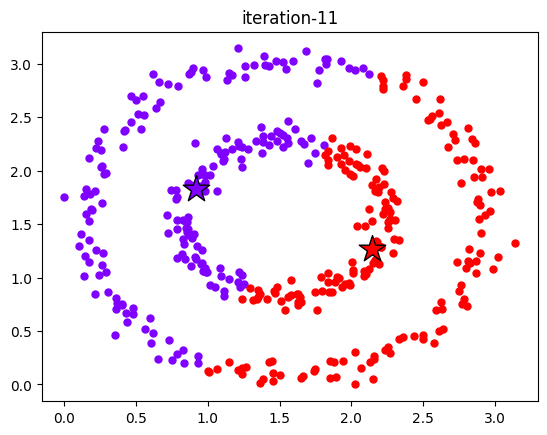

Cluster member numbers- 0 :  198
Cluster member numbers- 1 :  198
iteration- 12 :  5.0  seconds


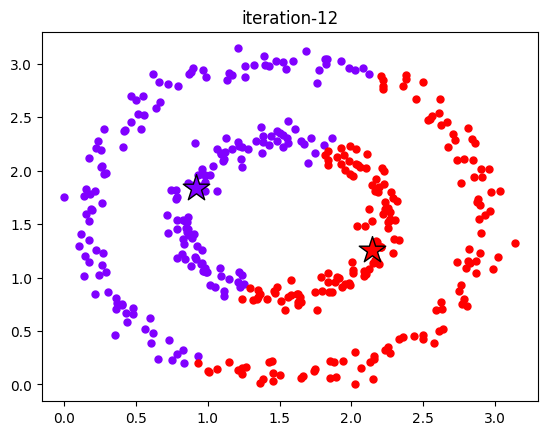

Cluster member numbers- 0 :  196
Cluster member numbers- 1 :  196
iteration- 13 :  6.0  seconds


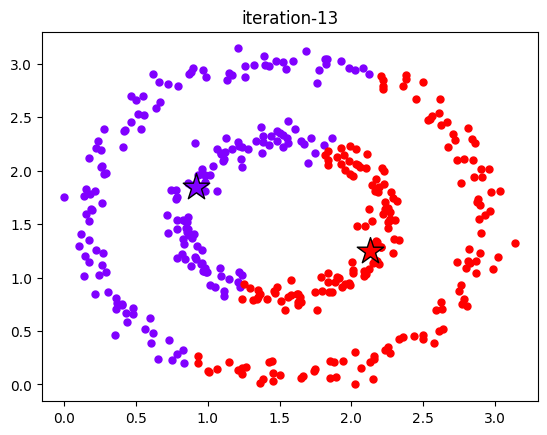

Cluster member numbers- 0 :  196
Cluster member numbers- 1 :  196
iteration- 14 :  6.0  seconds


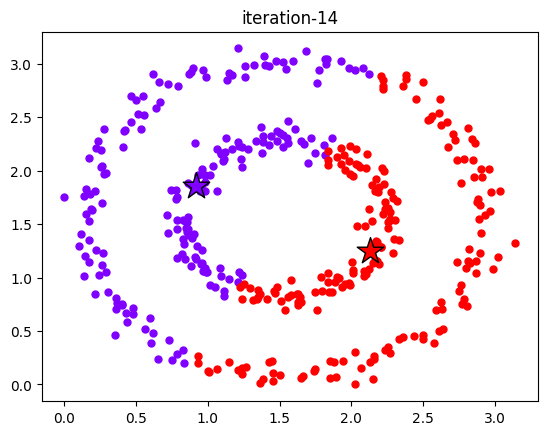

Cluster member numbers- 0 :  197
Cluster member numbers- 1 :  197
iteration- 15 :  6.0  seconds


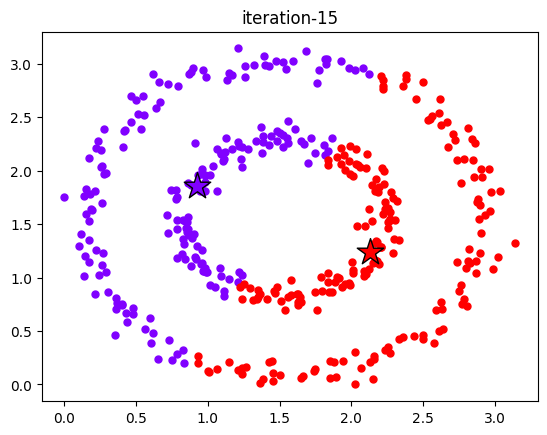

Cluster member numbers- 0 :  198
Cluster member numbers- 1 :  198
iteration- 16 :  6.0  seconds


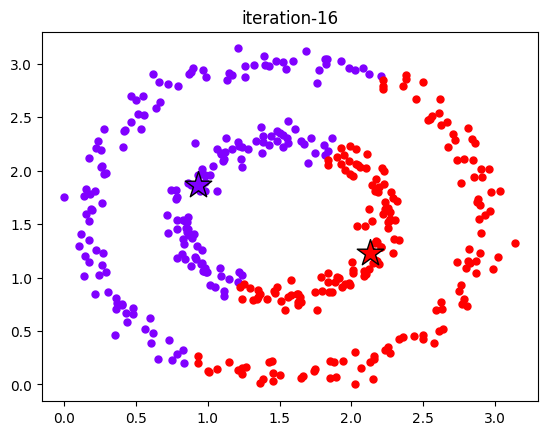

KeyboardInterrupt: 

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import time
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler


# Gerar dados
# X, _ = make_moons(n_samples=200, noise=0.05)
X, _ = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=42
)
scaler = MinMaxScaler(feature_range=(0, np.pi))  # Normalizar para rotações
X = scaler.fit_transform(X)

#params
k = 2 #number of cluster
var = 5 #var in RFB kernel
iterationCounter = 0
input = X
initMethod = "random" #options = random, byCenterDistance, byOriginDistance

def initCluster(dataInput, nCluster, method):
    listClusterMember = [[] for i in range(nCluster)]
    if (method == "random"):
        shuffledDataIn = dataInput
        np.random.shuffle(shuffledDataIn)
        for i in range(0, dataInput.shape[0]):
            listClusterMember[i%nCluster].append(dataInput[i,:])
    if (method == "byCenterDistance"):
        center = np.matrix(np.mean(dataInput, axis=0))
        repeatedCent = np.repeat(center, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int_(np.floor(i/divider))].append(dataNew[i,:])
    if (method == "byOriginDistance"):
        origin = np.matrix([[0,0]])
        repeatedCent = np.repeat(origin, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int_(np.floor(i/divider))].append(dataNew[i,:])

    return listClusterMember

def RbfKernel(data1, data2, sigma):
    delta =abs(np.subtract(data1, data2))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

def thirdTerm(memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        for j in range(0, memberCluster.shape[0]):
            result = result + RbfKernel(memberCluster[i, :], memberCluster[j, :], var)
    result = result / (memberCluster.shape[0] ** 2)
    return result

def secondTerm(dataI, memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        result = result + RbfKernel(dataI, memberCluster[i,:], var)
    result = 2 * result / memberCluster.shape[0]
    return result

def plotResult(listClusterMembers, centroid, iteration, converged):
    n = listClusterMembers.__len__()
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    plt.figure("result")
    plt.clf()
    plt.title("iteration-" + iteration)
    for i in range(n):
        col = next(color)
        memberCluster = np.asmatrix(listClusterMembers[i])
        plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]), marker=".", s=100, c=col)
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i in range(n):
        col = next(color)
        plt.scatter(np.ravel(centroid[i, 0]), np.ravel(centroid[i, 1]), marker="*", s=400, c=col, edgecolors="black")
    if (converged == 0):
        plt.ion()
        plt.show()
        plt.pause(0.1)
    if (converged == 1):
        plt.show(block=True)

def kMeansKernel(data, initMethod):
    global iterationCounter
    memberInit = initCluster(data, k, initMethod)
    nCluster = memberInit.__len__()
    #looping until converged
    while(True):
        # calculate centroid, only for visualization purpose
        centroid = np.ndarray(shape=(0, data.shape[1]))
        for i in range(0, nCluster):
            memberCluster = np.asmatrix(memberInit[i])
            centroidCluster = memberCluster.mean(axis=0)
            centroid = np.concatenate((centroid, centroidCluster), axis=0)
        #plot result in every iteration
        plotResult(memberInit, centroid, str(iterationCounter), 0)
        oldTime = np.around(time.time(), decimals=0)
        kernelResultClusterAllCluster = np.ndarray(shape=(data.shape[0], 0))
        #assign data to cluster whose centroid is the closest one
        for i in range(0, nCluster):#repeat for all cluster
            term3 = thirdTerm(np.asmatrix(memberInit[i]))
            matrixTerm3 = np.repeat(term3, data.shape[0], axis=0); matrixTerm3 = np.asmatrix(matrixTerm3)
            matrixTerm2 = np.ndarray(shape=(0,1))
            for j in range(0, data.shape[0]): #repeat for all data
                term2 = secondTerm(data[j,:], np.asmatrix(memberInit[i]))
                matrixTerm2 = np.concatenate((matrixTerm2, term2), axis=0)
            matrixTerm2 = np.asmatrix(matrixTerm2)
            kernelResultClusterI = np.add(-1*matrixTerm2, matrixTerm3)
            kernelResultClusterAllCluster =\
                np.concatenate((kernelResultClusterAllCluster, kernelResultClusterI), axis=1)
        clusterMatrix = np.ravel(np.argmin(np.matrix(kernelResultClusterAllCluster), axis=1))
        listClusterMember = [[] for l in range(k)]
        for i in range(0, data.shape[0]):#assign data to cluster regarding cluster matrix
            listClusterMember[clusterMatrix[i]].append(data[i,:])
        for i in range(0, nCluster):
            print("Cluster member numbers-", i, ": ", listClusterMember[0].__len__())
        #break when converged
        boolAcc = True
        for m in range(0, nCluster):
            prev = np.asmatrix(memberInit[m])
            current = np.asmatrix(listClusterMember[m])
            if (prev.shape[0] != current.shape[0]):
                boolAcc = False
                break
            if (prev.shape[0] == current.shape[0]):
                boolPerCluster = (prev == current).all()
            boolAcc = boolAcc and boolPerCluster
            if(boolAcc==False):
                break
        if(boolAcc==True):
            break
        iterationCounter += 1
        #update new cluster member
        memberInit = listClusterMember
        newTime = np.around(time.time(), decimals=0)
        print("iteration-", iterationCounter, ": ", newTime - oldTime, " seconds")
    return listClusterMember, centroid

clusterResult, centroid = kMeansKernel(input, initMethod)
plotResult(clusterResult, centroid, str(iterationCounter) + ' (converged)', 1)
print("converged!")

Converged at iteration 2
Converged at iteration 3
Converged at iteration 4
Converged at iteration 5
Converged at iteration 6
Converged at iteration 7
Converged at iteration 8
Converged at iteration 9
Converged at iteration 10
Converged at iteration 11
Converged at iteration 12
Converged at iteration 13
Converged at iteration 14
Converged at iteration 15
Converged at iteration 16
Converged at iteration 17
Converged at iteration 18
Converged at iteration 19
Converged at iteration 20
Converged at iteration 21
Converged at iteration 22
Converged at iteration 23
Converged at iteration 24
Converged at iteration 25
Converged at iteration 26
Converged at iteration 27
Converged at iteration 28
Converged at iteration 29
Converged at iteration 30
Converged at iteration 31
Converged at iteration 32
Converged at iteration 33
Converged at iteration 34
Converged at iteration 35
Converged at iteration 36
Converged at iteration 37
Converged at iteration 38
Converged at iteration 39
Converged at iterati

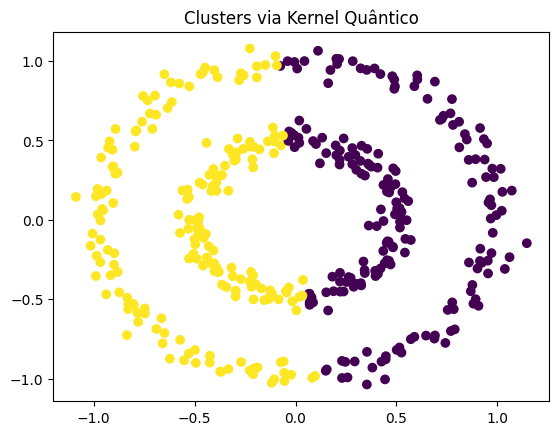

In [18]:
"""Kernel K-means"""

# Author: Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                # break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

if __name__ == '__main__':
    from sklearn.datasets import make_moons
    X, _ = make_circles(
        (200, 200), factor=0.5, noise=0.05, random_state=42
    )
    km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1)
    
    predictions = km.fit_predict(X)

    fig = plt.Figure()

    # Visualização
    plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap="viridis")
    plt.title("Clusters via Kernel Quântico")
    plt.show()

    # print(km.predict(X[:10]))

/opt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 400 1-dimensional timeseries
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Pa

Init 1
464.706 --> 379.146 --> 373.322 --> 370.828 --> 368.182 --> 365.808 --> 364.559 --> 363.417 --> 362.756 --> 362.235 --> 361.616 --> 360.833 --> 360.016 --> 359.148 --> 358.779 --> 358.459 --> 358.105 --> 357.667 --> 357.404 --> 357.289 --> 357.200 --> 357.185 --> 357.173 --> 357.173 --> 
Init 2
471.368 --> 390.132 --> 367.993 --> 361.818 --> 360.126 --> 359.596 --> 358.988 --> 358.741 --> 358.488 --> 357.923 --> 357.482 --> 357.227 --> 357.056 --> 357.060 --> 357.060 --> 
Init 3
459.390 --> 358.875 --> 357.215 --> 357.083 --> 357.047 --> 357.047 --> 
Init 4
472.590 --> 373.653 --> 361.745 --> 359.551 --> 359.115 --> 358.788 --> 358.526 --> 358.066 --> 357.609 --> 357.294 --> 357.102 --> 357.056 --> 357.060 --> 357.060 --> 
Init 5
467.977 --> 378.424 --> 374.482 --> 372.148 --> 369.496 --> 366.844 --> 364.927 --> 363.562 --> 362.756 --> 362.235 --> 361.616 --> 360.833 --> 360.016 --> 359.148 --> 358.779 --> 358.459 --> 358.105 --> 357.667 --> 357.404 --> 357.289 --> 357.200 --> 3

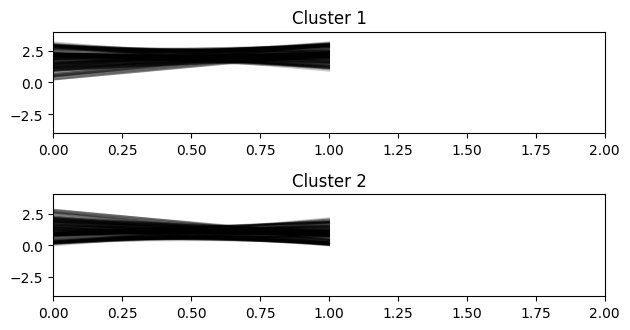

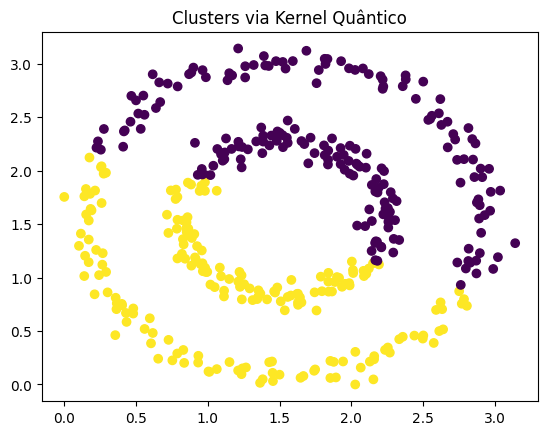

In [30]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes
X_train = X_train[y_train < 4]
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])

X, _ = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=42
)
scaler = MinMaxScaler(feature_range=(0, np.pi))  # Normalizar para rotações
X = scaler.fit_transform(X)

sz = X.shape[1]

gak_km = KernelKMeans(n_clusters=2,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(X)

plt.figure()
for yi in range(2):
    plt.subplot(3, 1, 1 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()


fig = plt.Figure()

# Visualização
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="viridis")
plt.title("Clusters via Kernel Quântico")
plt.show()


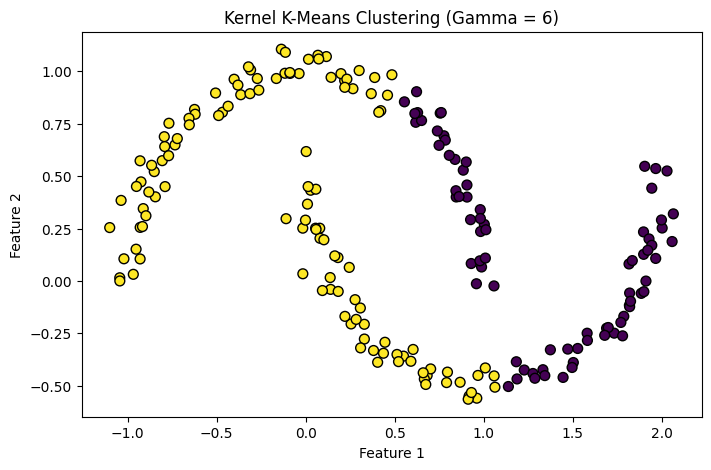

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Gerar o dataset moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)

# Parâmetros do kernel RBF
gamma = 7  # Ajuste este valor conforme necessário

# Calcular a matriz do kernel RBF
sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
K = np.exp(-gamma * sq_dists)

# Inicialização do Kernel K-Means
n_clusters = 2
np.random.seed(42)
clusters = np.random.randint(0, n_clusters, X.shape[0])
max_iter = 100

# Algoritmo Kernel K-Means
for it in range(max_iter):
    distances = np.zeros((X.shape[0], n_clusters))
    
    for k in range(n_clusters):
        mask = (clusters == k)
        if mask.sum() == 0:
            continue  # Cluster vazio (pode reinicializar se necessário)
        
        # Calcular termos do kernel para o cluster k
        sum_K = K[:, mask].sum(axis=1)
        sum_K2 = K[mask][:, mask].sum()
        n_k = mask.sum()
        
        # Distância no espaço do kernel
        distances[:, k] = np.diag(K) - (2 / n_k) * sum_K + (sum_K2) / (n_k ** 2)
    
    new_clusters = np.argmin(distances, axis=1)
    
    if np.array_equal(clusters, new_clusters):
        break  # Convergência
    clusters = new_clusters

# Plotar os resultados
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=50, edgecolors='k')
plt.title('Kernel K-Means Clustering (Gamma = {})'.format(gamma))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()